In [188]:
import torch

# 데이터 확인

In [189]:
# case 1
N=20
random0=torch.randn(int(N/2),1) # torch.randn(10,1) & shape = 10,1
random5=torch.randn(int(N/2),1)+5
class1_data=torch.hstack([random0,random5]) # shape=10,2
class2_data=torch.hstack([random5,random0]) # shape=10,2
class1_label=torch.ones(int(N/2),1) # 10,1
class2_label=torch.zeros(int(N/2),1)
X=torch.vstack([class1_data,class2_data]) # 20,2
y=torch.vstack([class1_label,class2_label]) # 20,1

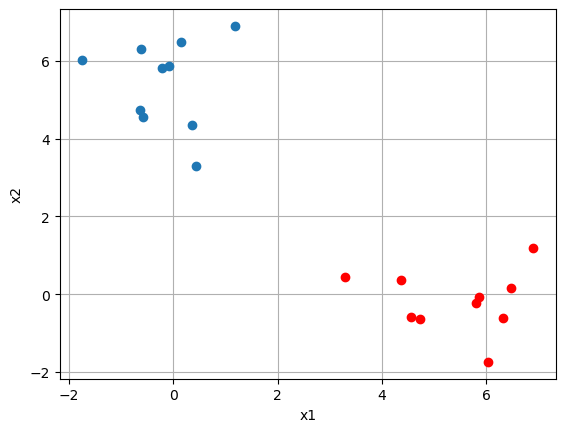

In [190]:
import matplotlib.pyplot as plt
plt.plot(class1_data[:,0],class1_data[:,1],'o')
plt.plot(class2_data[:,0],class2_data[:,1],'ro')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

# 모델 만들기

In [191]:
from torch import nn

In [192]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear = nn.Sequential(
      nn.Linear(2,100), # 2개의 채널, 20개의 데이터이므로
      nn.Sigmoid(),
      nn.Linear(100,1), # 이진분류이므로, 1개로 출력! (=q값)
      nn.Sigmoid()
    )

  def forward(self, x):
    x = self.linear(x)
    return x

In [193]:
model = MLP()
print(model)

MLP(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [194]:
print(model(torch.randn(5,2)).shape)

torch.Size([5, 1])


# 모델 학습

In [195]:
from torch import optim
import torch.nn.functional as F

hyperparameter 설정 

In [196]:
lr = 1e-1 # e^-1 = 0.1
epoch = 100

BCE 수식 확인

$-\sum(log \hat{y}^y * (1-\hat{y})^{1-y})$

In [197]:
y_hat = model(X)
print(F.binary_cross_entropy(y_hat, y))
print(-torch.sum(torch.log(y_hat**y*(1-y_hat)**(1-y)))/N)

tensor(0.6948, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6948, grad_fn=<DivBackward0>)


defalut로 mean이 들어가있다

In [198]:
x = torch.tensor([1.], requires_grad=True)
for _ in range(3):
  loss=x**2
  loss.backward()
  print(x.grad)

tensor([2.])
tensor([4.])
tensor([6.])


x.grad가 누적이 된다
- 이를 방지하기 위해서는 x.grad = None 필요

In [199]:
x = torch.tensor([1.], requires_grad=True)
for _ in range(3):
  loss=x**2
  loss.backward()
  print(x.grad)
  x.grad = None

tensor([2.])
tensor([2.])
tensor([2.])


In [200]:
def train_model(model, X, y, epoch, lr):
  optimizer = optim.SGD(model.parameters(), lr=lr)
  model.train()

  loss_hist = []
  for ep in range(epoch):
    y_hat = model(X) # model 예측값
    loss = F.binary_cross_entropy(y_hat, y) # 예측값과 실제 값 y에 대한 BCE 계산

    optimizer.zero_grad() # 누적되는 것을 방지

    loss.backward() # update, gradient descent 미분 계산; dL/dW
    optimizer.step() # gradient descent 업데이트 공식 계산; W-ag
    print("-"*20)
    print(f"Epoch : {ep}, train loss : {loss.item()}")
    loss_hist += [loss.item()] # loss 확인
  return loss_hist

def loss_plot(loss_hist):
  plt.plot(range(1,epoch+1),loss_hist)
  plt.xlabel('Epoch')
  plt.ylabel('loss')

In [201]:
loss_hist = train_model(model, X, y, epoch, lr)

--------------------
Epoch : 0, train loss : 0.6948184967041016
--------------------
Epoch : 1, train loss : 0.5519492030143738
--------------------
Epoch : 2, train loss : 0.45013540983200073
--------------------
Epoch : 3, train loss : 0.37599489092826843
--------------------
Epoch : 4, train loss : 0.3206389844417572
--------------------
Epoch : 5, train loss : 0.278251975774765
--------------------
Epoch : 6, train loss : 0.24502556025981903
--------------------
Epoch : 7, train loss : 0.21842817962169647
--------------------
Epoch : 8, train loss : 0.19674131274223328
--------------------
Epoch : 9, train loss : 0.17877118289470673
--------------------
Epoch : 10, train loss : 0.1636696755886078
--------------------
Epoch : 11, train loss : 0.15082120895385742
--------------------
Epoch : 12, train loss : 0.13977034389972687
--------------------
Epoch : 13, train loss : 0.13017387688159943
--------------------
Epoch : 14, train loss : 0.12176898866891861
--------------------
Epoch

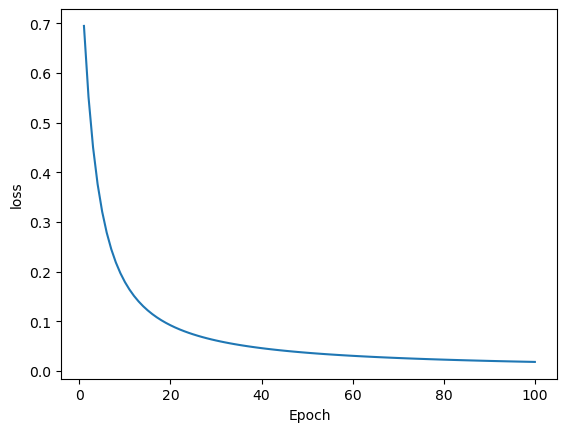

In [202]:
loss_plot(loss_hist)

# 모델 테스트

In [203]:
x1_test=torch.linspace(-10,10,30) # -10~10까지 30개
x2_test=torch.linspace(-10,10,30)
X1_test, X2_test=torch.meshgrid(x1_test,x2_test) # 좌표평면을 만드는 함수 > (1,1), (1,2), ...
# X1_test : x의 좌표, X2_test : y의 좌표
X_test=torch.cat([X1_test.unsqueeze(dim=2), X2_test.unsqueeze(dim=2)], dim=2) # (30,30,1) + (30,30,1) => shape (30,30,2)
print(X_test.shape) # (30,30,2)

def test_model(model, X_test):
  model.eval() # test model
  # dropout, BN 등 train과 test 모드 동작이 다른 경우 eval()를 바꿔줘야 한다
  with torch.no_grad(): # test 단계시 메모리 방지를 위해 no_grad
    y_hat = model(X_test)
  Y_hat = y_hat.squeeze()
  # print(y_hat)
  # print(model.training) # test, train mode 확인

  plt.figure(figsize=[10, 9]) # figsize=[가로, 세로]
  ax = plt.axes(projection="3d")
  ax.view_init(elev=25,azim=-140)
  ax.plot_surface(X1_test,X2_test, Y_hat.numpy(), cmap="viridis", alpha=0.2)
  plt.plot(class1_data[:,0],class1_data[:,1],class1_label.squeeze(),'bo')
  plt.plot(class2_data[:,0],class2_data[:,1],class2_label.squeeze(),'ro')
  plt.xlabel("x1")
  plt.ylabel("x2")

torch.Size([30, 30, 2])


/Users/lee/opt/anaconda3/envs/DL/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/Users/lee/opt/anaconda3/envs/DL/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.on

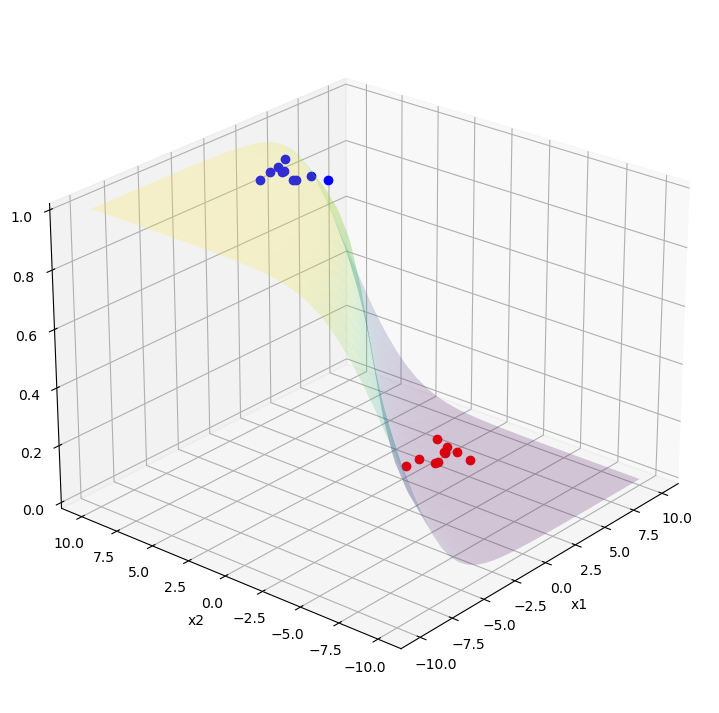

In [204]:
test_model(model, X_test)

In [205]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(x=X1_test, y=X2_test, z=Y_hat, colorscale="viridis", opacity=0.5)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))
fig.update_layout(title='binary classification', width=700, height=600)

ModuleNotFoundError: No module named 'plotly'

## node 개수를 줄여 확인

In [206]:
class MLP_node10(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear = nn.Sequential(
      nn.Linear(2,10), # 2개의 채널, 20개의 데이터이므로
      nn.Sigmoid(),
      nn.Linear(10,1), # 이진분류이므로, 1개로 출력! (=q값)
      nn.Sigmoid()
    )

  def forward(self, x):
    x = self.linear(x)
    return x

--------------------
Epoch : 0, train loss : 0.67682284116745
--------------------
Epoch : 1, train loss : 0.6443330645561218
--------------------
Epoch : 2, train loss : 0.6148144602775574
--------------------
Epoch : 3, train loss : 0.5878709554672241
--------------------
Epoch : 4, train loss : 0.5631605386734009
--------------------
Epoch : 5, train loss : 0.5403902530670166
--------------------
Epoch : 6, train loss : 0.5193116068840027
--------------------
Epoch : 7, train loss : 0.49971428513526917
--------------------
Epoch : 8, train loss : 0.4814208447933197
--------------------
Epoch : 9, train loss : 0.4642818570137024
--------------------
Epoch : 10, train loss : 0.4481712281703949
--------------------
Epoch : 11, train loss : 0.43298253417015076
--------------------
Epoch : 12, train loss : 0.4186253547668457
--------------------
Epoch : 13, train loss : 0.4050229489803314
--------------------
Epoch : 14, train loss : 0.3921095132827759
--------------------
Epoch : 15, tr

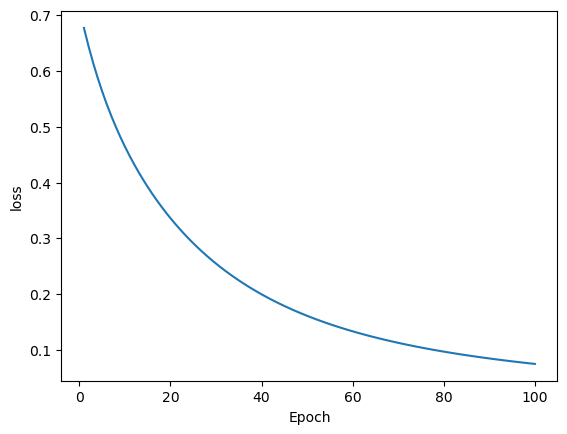

In [207]:
m_10 = MLP_node10()
loss_hi = train_model(m_10, X, y, epoch, lr)
loss_plot(loss_hi)

아까보다 더 loss값 높은 것 확인

/Users/lee/opt/anaconda3/envs/DL/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/Users/lee/opt/anaconda3/envs/DL/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.on

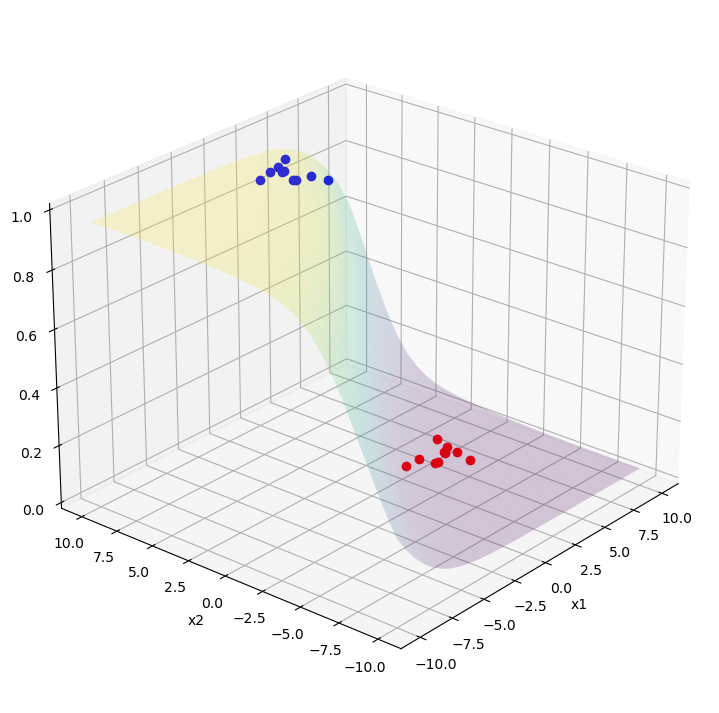

In [208]:
test_model(m_10, X_test)

## node 개수를 늘렸을 때?

In [209]:
class MLP_node10000(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear = nn.Sequential(
      nn.Linear(2,10000), # 2개의 채널, 20개의 데이터이므로
      nn.Sigmoid(),
      nn.Linear(10000,1), # 이진분류이므로, 1개로 출력! (=q값)
      nn.Sigmoid()
    )

  def forward(self, x):
    x = self.linear(x)
    return x

--------------------
Epoch : 0, train loss : 0.7362656593322754
--------------------
Epoch : 1, train loss : 0.0
--------------------
Epoch : 2, train loss : 0.0
--------------------
Epoch : 3, train loss : 0.0
--------------------
Epoch : 4, train loss : 0.0
--------------------
Epoch : 5, train loss : 0.0
--------------------
Epoch : 6, train loss : 0.0
--------------------
Epoch : 7, train loss : 0.0
--------------------
Epoch : 8, train loss : 0.0
--------------------
Epoch : 9, train loss : 0.0
--------------------
Epoch : 10, train loss : 0.0
--------------------
Epoch : 11, train loss : 0.0
--------------------
Epoch : 12, train loss : 0.0
--------------------
Epoch : 13, train loss : 0.0
--------------------
Epoch : 14, train loss : 0.0
--------------------
Epoch : 15, train loss : 0.0
--------------------
Epoch : 16, train loss : 0.0
--------------------
Epoch : 17, train loss : 0.0
--------------------
Epoch : 18, train loss : 0.0
--------------------
Epoch : 19, train loss :

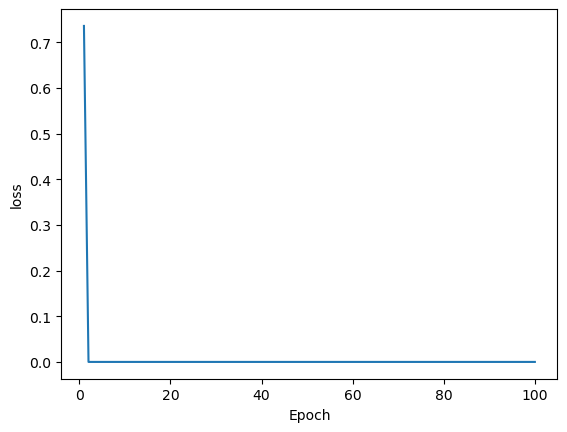

In [210]:
MLP_10000 = MLP_node10000()
loss_10000 = train_model(MLP_10000, X, y, epoch, lr)
loss_plot(loss_10000)

/Users/lee/opt/anaconda3/envs/DL/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/Users/lee/opt/anaconda3/envs/DL/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.on

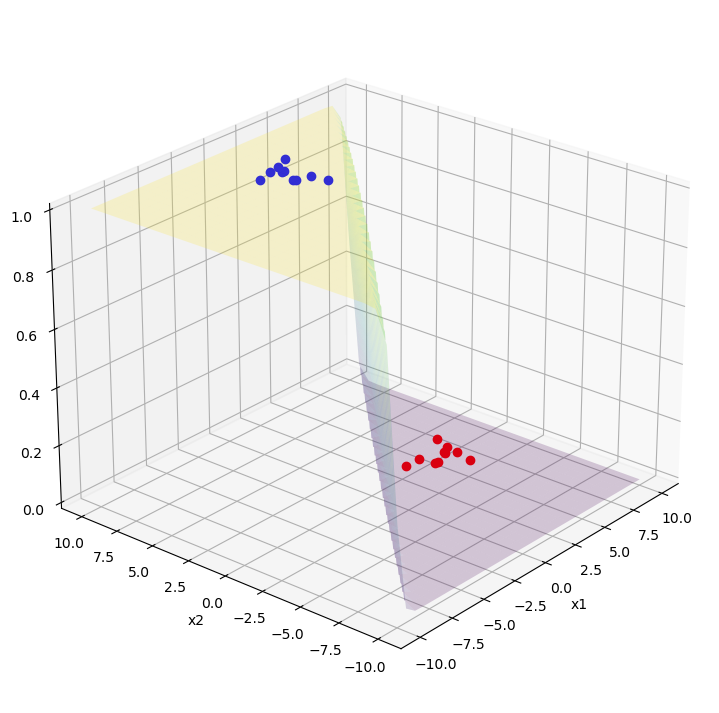

In [211]:
test_model(MLP_10000, X_test)

이런식으로 노드를 확 줄이거나, hidden layer을 줄이거나 늘리거나 등 확인 가능

# optimizer Adam

In [216]:
model = MLP_node10000()

model.train()
optimizer = optim.Adam(model.parameters(), lr=lr)

loss_hist = []
for ep in range(epoch):
  y_hat = model(X) # model 예측값
  loss = F.binary_cross_entropy(y_hat, y) # 예측값과 실제 값 y에 대한 BCE 계산

  optimizer.zero_grad() # 누적되는 것을 방지

  loss.backward() # update, gradient descent 미분 계산; dL/dW
  optimizer.step() # gradient descent 업데이트 공식 계산; W-ag
  print("-"*20)
  print(f"Epoch : {ep}, train loss : {loss.item()}")
  loss_hist += [loss.item()] # loss 확인

--------------------
Epoch : 0, train loss : 0.7207337617874146
--------------------
Epoch : 1, train loss : 0.08190282434225082
--------------------
Epoch : 2, train loss : 0.0
--------------------
Epoch : 3, train loss : 0.0
--------------------
Epoch : 4, train loss : 0.0
--------------------
Epoch : 5, train loss : 0.0
--------------------
Epoch : 6, train loss : 0.0
--------------------
Epoch : 7, train loss : 0.5655406713485718
--------------------
Epoch : 8, train loss : 0.0
--------------------
Epoch : 9, train loss : 0.0
--------------------
Epoch : 10, train loss : 0.0
--------------------
Epoch : 11, train loss : 0.0
--------------------
Epoch : 12, train loss : 0.0
--------------------
Epoch : 13, train loss : 0.0
--------------------
Epoch : 14, train loss : 0.0
--------------------
Epoch : 15, train loss : 0.0
--------------------
Epoch : 16, train loss : 0.0
--------------------
Epoch : 17, train loss : 0.0
--------------------
Epoch : 18, train loss : 0.0
--------------

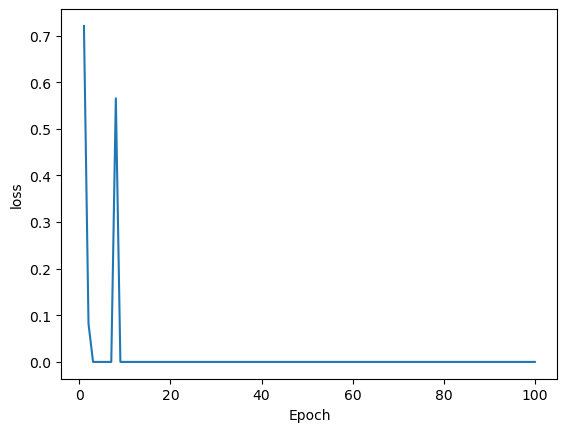

In [217]:
loss_plot(loss_hist)

/Users/lee/opt/anaconda3/envs/DL/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/Users/lee/opt/anaconda3/envs/DL/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.on

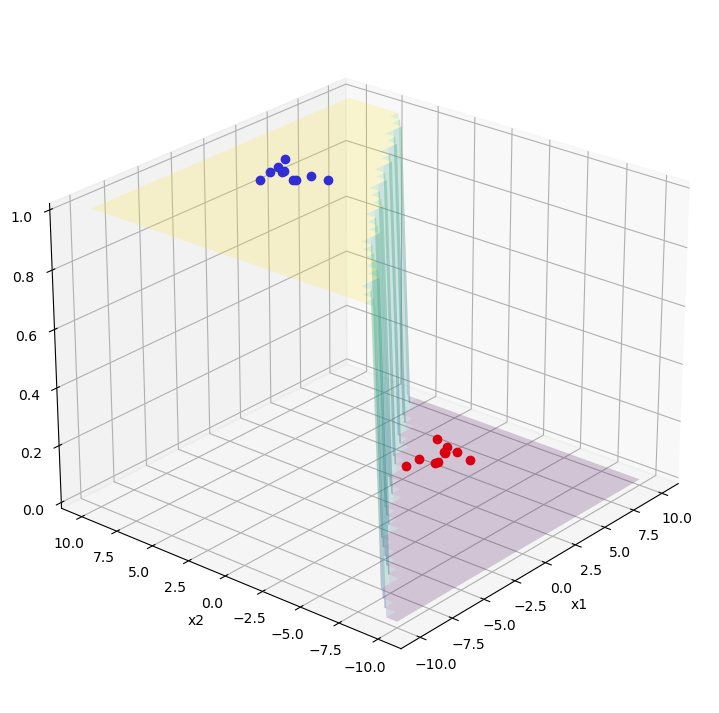

In [218]:
test_model(model, X_test)

# 다른 데이터로 실험

In [225]:
# case 2
N=100
radius1=0.3+0.05*torch.randn(int(N/2),1)
radius2=1+0.01*torch.randn(int(N/2),1)
theta1=2*torch.pi*torch.rand(int(N/2),1)-torch.pi
theta2=2*torch.pi*torch.rand(int(N/2),1)-torch.pi
class1_data=torch.hstack([radius1*torch.cos(theta1), radius1*torch.sin(theta1)])
class2_data=torch.hstack([radius2*torch.cos(theta2), radius2*torch.sin(theta2)])
class1_label=torch.ones(int(N/2),1)
class2_label=torch.zeros(int(N/2),1)
X=torch.vstack([class1_data,class2_data])
y=torch.vstack([class1_label,class2_label])

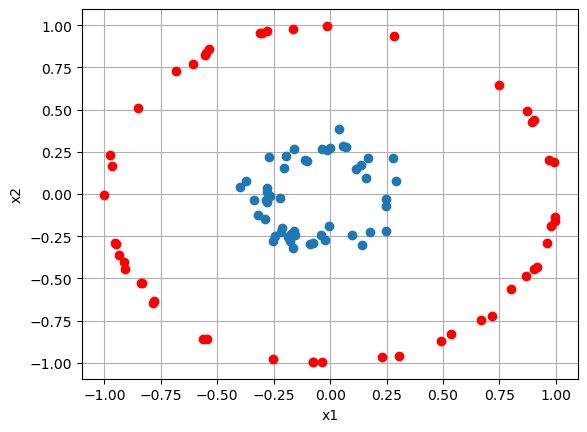

In [226]:
import matplotlib.pyplot as plt
plt.plot(class1_data[:,0],class1_data[:,1],'o')
plt.plot(class2_data[:,0],class2_data[:,1],'ro')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

중간만 1, 가장자리만 0으로 나와야하는 데이터

In [228]:
model = MLP()

optimizer = optim.Adam(model.parameters(), lr=lr)
model.train()

loss_hist = []
for ep in range(epoch):
  y_hat = model(X) # model 예측값
  loss = F.binary_cross_entropy(y_hat, y) # 예측값과 실제 값 y에 대한 BCE 계산

  optimizer.zero_grad() # 누적되는 것을 방지

  loss.backward() # update, gradient descent 미분 계산; dL/dW
  optimizer.step() # gradient descent 업데이트 공식 계산; W-ag
  print("-"*20)
  print(f"Epoch : {ep}, train loss : {loss.item()}")
  loss_hist += [loss.item()] # loss 확인

--------------------
Epoch : 0, train loss : 0.6959773302078247
--------------------
Epoch : 1, train loss : 2.5449330806732178
--------------------
Epoch : 2, train loss : 0.945993959903717
--------------------
Epoch : 3, train loss : 1.262126088142395
--------------------
Epoch : 4, train loss : 1.6707525253295898
--------------------
Epoch : 5, train loss : 1.3638612031936646
--------------------
Epoch : 6, train loss : 0.8384860157966614
--------------------
Epoch : 7, train loss : 0.7214108109474182
--------------------
Epoch : 8, train loss : 1.001785159111023
--------------------
Epoch : 9, train loss : 1.1314204931259155
--------------------
Epoch : 10, train loss : 1.027586579322815
--------------------
Epoch : 11, train loss : 0.8161449432373047
--------------------
Epoch : 12, train loss : 0.6847144961357117
--------------------
Epoch : 13, train loss : 0.7249459028244019
--------------------
Epoch : 14, train loss : 0.826957643032074
--------------------
Epoch : 15, train l

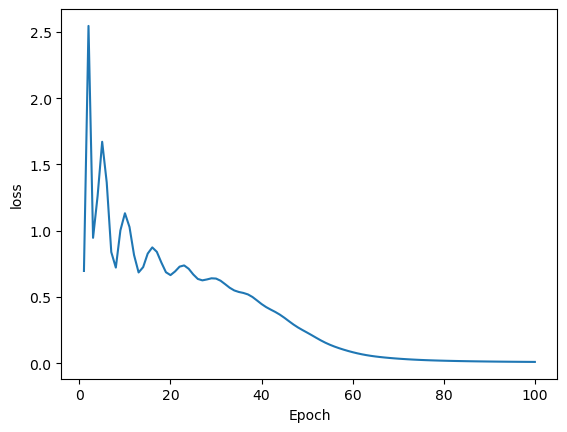

In [229]:
loss_plot(loss_hist)

In [230]:
x1_test=torch.linspace(-2,2,30) # case 2
x2_test=torch.linspace(-2,2,30) # case 2
X1_test, X2_test=torch.meshgrid(x1_test,x2_test)
X_test=torch.cat([X1_test.unsqueeze(dim=2), X2_test.unsqueeze(dim=2)], dim=2)
print(X_test.shape)

def test_model(model, X_test):
  model.eval()
  with torch.no_grad():
    y_hat = model(X_test)
  Y_hat = y_hat.squeeze()

  plt.figure(figsize=[10, 9])
  ax = plt.axes(projection="3d")
  ax.view_init(elev=25,azim=-140)
  ax.plot_surface(X1_test,X2_test, Y_hat.numpy(), cmap="viridis", alpha=0.2)
  plt.plot(class1_data[:,0],class1_data[:,1],class1_label.squeeze(),'bo')
  plt.plot(class2_data[:,0],class2_data[:,1],class2_label.squeeze(),'ro')
  plt.xlabel("x1")
  plt.ylabel("x2")

torch.Size([30, 30, 2])


/Users/lee/opt/anaconda3/envs/DL/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/Users/lee/opt/anaconda3/envs/DL/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.on

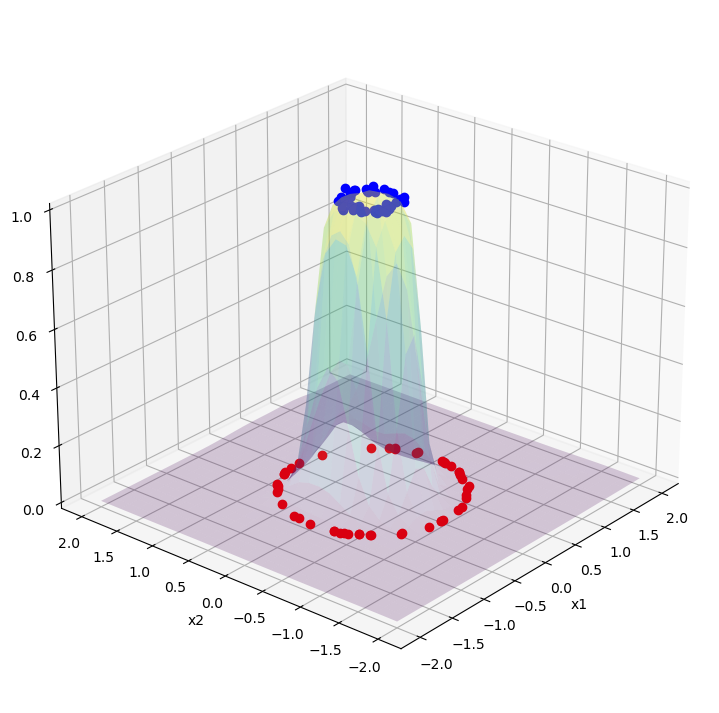

In [231]:
test_model(model, X_test)

만약 학습이 되지 않을 때 (=loss가 줄어들지 않고 발산했을 때) 최대가 100이다
- 원래는 1일 때 0으로 모델이 예측했다고 하면, inf가 나와야한다
- 하지만 BCE에서 log의 최대치를 -100으로 막아두었기 때문에, 100으로 나오는 것